#### Import libraries for forecasting time series with ARIMA

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib.ticker as ticker
from os.path import join
from datetime import datetime, date, time, timedelta
from pytz import timezone
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams
from kp import ImportData, Description
rcParams['figure.figsize'] = 10,6

**Components of Time Series**

* Trend - Upward & downward movement of the data with time over a large period of time
* Seasonality - seasonal variances.
* Noice of Irregularity - Spikes & troughs at random intervals.
* Cyclicity - behavior that repeats itself after large interval of time, like onths, years, etc.

**Stationarity**

Before applying any statistical model on a Time Series, the series has to be stationary, which meand that, over different time periods:
* it should have constant mean
* it should have constant variance or standard deviation
* auto-covariance should not depend on time

**_Trend & Seasonality are two reasons why a Time Series is not stationary & hence need to be corrected._**

Time Series need to be stationary because of the following reasons:
* If TS has a particular behavior over a time interval, then there's a high probability that over a different interval, it will have same behavior, provided TX is stationary. This helps forecasting accuretely.
* Theories & Mathematical formulas are more mature & easier to apply for as TS which is stationary.

**Test to check if a series is stationary or not**

There are 2 ways to check for Stationarity of a TS:
* Roling Statistics - Plot the moving avg or moving standard deviation to see if it varies with time, its a visual technique.
* ADCF test - Augmented Dickey-Fuller test is used to gives us various values that can help in identifying stationarity. The Null hypothesis says that a TS is non-stationary. It comprises of a Test Statistics & some critical values for some confidence levels. If the Test statistics is less than the critical values, we can reject the null hypothesis & say that the series is stationary. The ADCF test also give a p-value. Acc to the null hypothesis, lower values of p is better.

**ARIMA** (Auto Regressive Integrated Movind Average) is a combination of 2 models AR (Auto Regressive) & MA (Moving Average). It has 3 hyperparameters - P(auto regresive lags), d(order of differentiation), Q(moving avg.), which respectively comes form the AR, I & MA components. The AR part is correlation between prev & current time periods. To smooth out the noise, the MA part is used. The I part binds together the AR & MA parts.

In [2]:
# read data
daily = ImportData.daily()
description = Description.description
amr_data = daily['AMR']
amr_data_d = amr_data[amr_data.index.duplicated(keep=False)]
amr_data.head()

TimeStamp
2020-01-01 02:00:00    59189
2020-01-01 03:00:00    46974
2020-01-01 04:00:00    31644
2020-01-01 05:00:00    19679
2020-01-01 06:00:00    22828
Freq: H, Name: AMR, dtype: int64

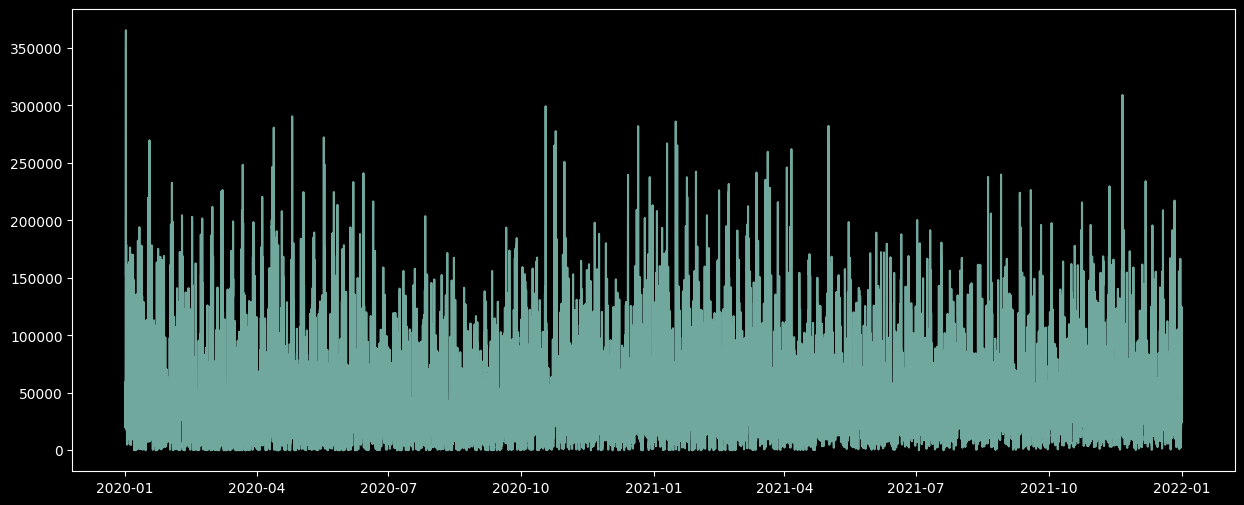

In [65]:
# plot graph
plt.figure(figsize=(15,6))
plt.plot(amr_data, alpha=0.8)
plt.show()

In [66]:
#Determine rolling statistics
window = 24
rolmean = amr_data.rolling(window=window).mean()
rolstd = amr_data.rolling(window=window).std()

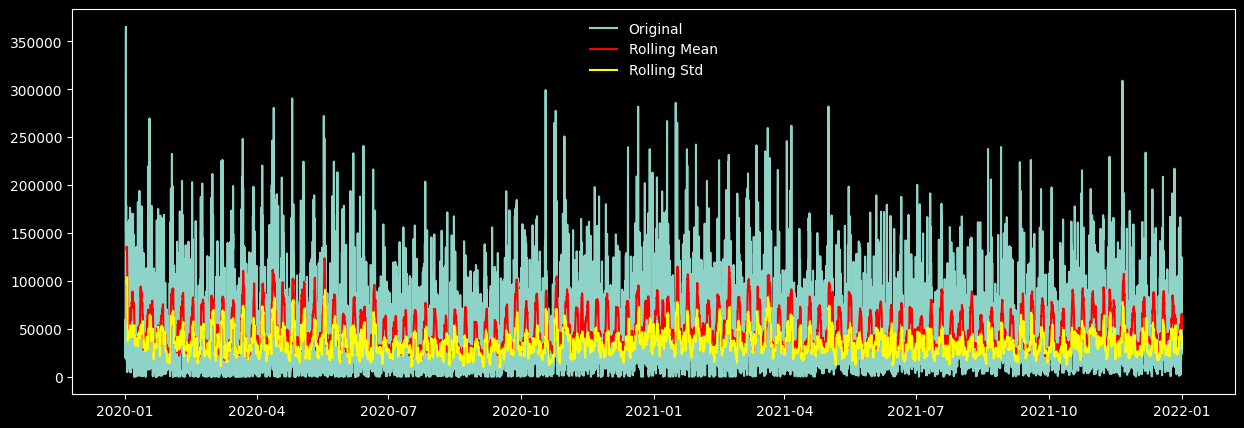

In [67]:
#Plot rolling statistics
plt.figure(figsize=(15,5))
org = plt.plot(amr_data, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='yellow', label='Rolling Std')
plt.legend(frameon=False)
plt.show()

From the above graph, we see that rolling mean and rolling standard deviation is fairly constatnt with time. The curves for both of statistics are parallel to the x-axis, which in our case is ok.

In [68]:
# Perform Augmented Dickey-Fuller test:
dftest = adfuller(amr_data, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], 
        index=['Test Statistic', 'p-value', 'Lags Used', 'Number Observations Used'])
for k, v in dftest[4].items():
        dfoutput[f'Critical Value {k}'] = v

In [69]:
dfoutput

Test Statistic             -1.842684e+01
p-value                     2.171774e-30
Lags Used                   4.400000e+01
Number Observations Used    1.749900e+04
Critical Value 1%          -3.430724e+00
Critical Value 5%          -2.861705e+00
Critical Value 10%         -2.566858e+00
dtype: float64

For a time series to be stationary, ADCF test should have:
1. p-value to be low (according to the null hypothesis)
2. The critical values at 1%, 5%, 10% confidence intervals should be as close as possible to the Test Statistics.

From the above ADCF test result, we see that p-value is very small, and critical values are not bigger than Test Statistics. 

Low p-value reject null hypothesis, so time series are stationary.

#### Decomposition

In [70]:
decomposition = seasonal_decompose(pd.DataFrame(amr_data, columns = ['AMR']), period = window)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

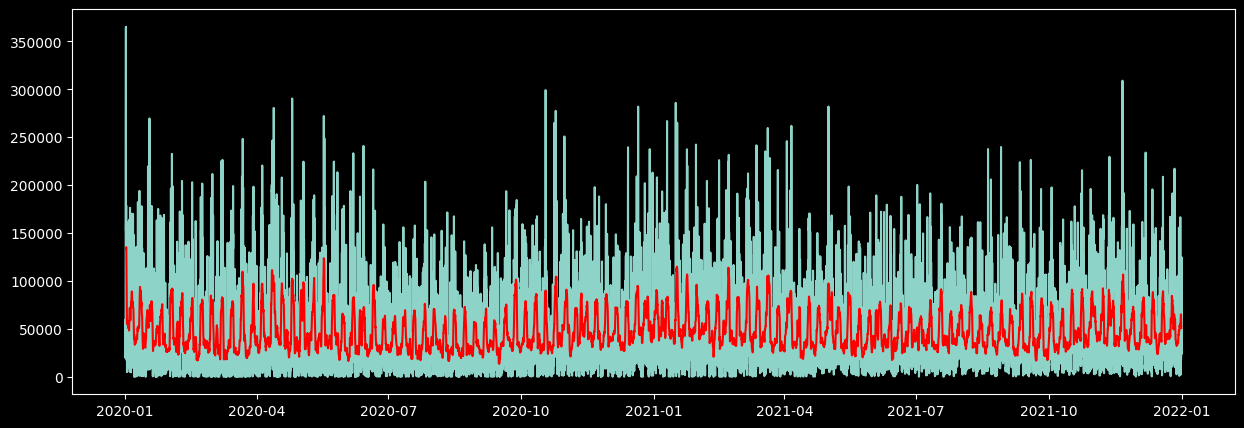

In [71]:
plt.figure(figsize=(15,5))
org = plt.plot(amr_data, label='Original')
plt.plot(trend, color='red', label = '4 weeks Trend')
plt.show()

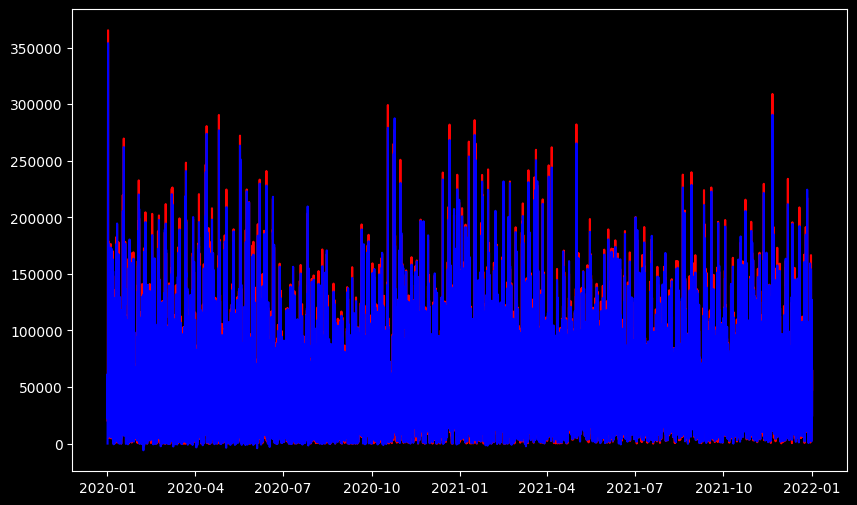

In [72]:
#AR model
model = ARIMA(amr_data, order=(2,1,0))
results_AR = model.fit()

org = plt.plot(amr_data, label='Original', color='red')
plt.plot(results_AR.fittedvalues, color='blue')

plt.show()

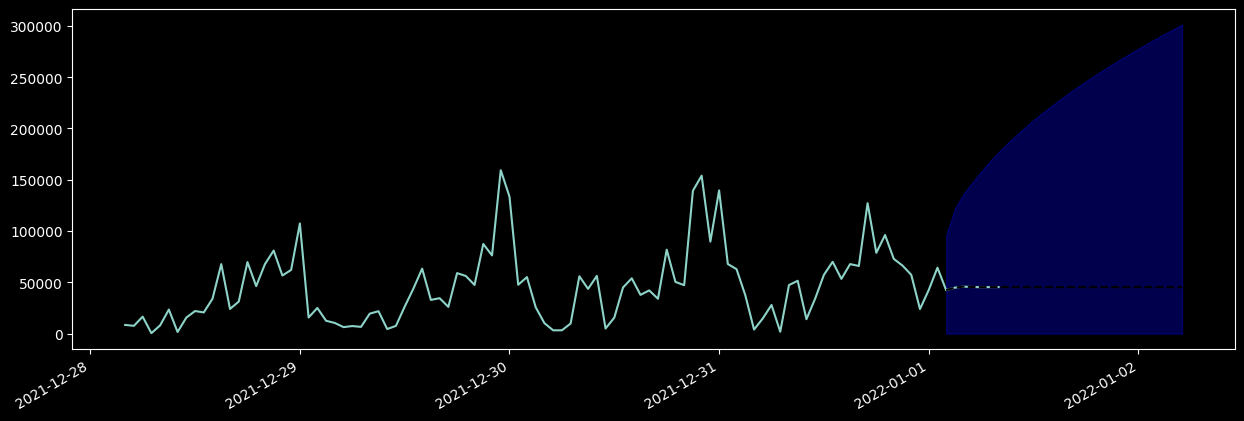

In [73]:
forecast=results_AR.forecast(10)
predict=results_AR.predict(start=17450, end=17550)

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)

ax.plot(predict)
fcast = results_AR.get_forecast(28).summary_frame()
fcast['mean_ci_lower'] = 0
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='blue', alpha=0.3)
plt.show()


In [74]:
# forecast for 100 periods

results_AR.get_forecast(100).summary_frame()

AMR,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-01-01 02:00:00,42308.037686,27247.812818,-11096.694094,95712.769465
2022-01-01 03:00:00,44855.961761,39404.622449,-32375.679063,122087.602586
2022-01-01 04:00:00,45814.384284,46228.280524,-44791.380610,136420.149178
2022-01-01 05:00:00,45450.734399,51989.111333,-56446.051402,147347.520201
2022-01-01 06:00:00,45281.583635,57453.327344,-67324.868750,157888.036021
...,...,...,...,...
2022-01-05 01:00:00,45351.046694,240134.958377,-425304.823153,516006.916541
2022-01-05 02:00:00,45351.046694,241375.546042,-427736.330297,518438.423686
2022-01-05 03:00:00,45351.046694,242609.790033,-430155.404067,520857.497455
2022-01-05 04:00:00,45351.046694,243837.786679,-432562.233266,523264.326654
